In [1]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import sys
import numpy as np
import json
import time
import os
import math

In [2]:
root_path = "data/full/prepared/train"
reference_data_root = f"{root_path}data_bcgw/"
raw_data_root = f"{root_path}data_img/"

In [3]:
def get_run_logdir(root_logdir):
    import time
    run_id = time.strftime("run__%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)


In [82]:
    n_skip = 5
    n_est = 1000
    m_depth = 8
    target = {
        "conifer" : "CONIFER.bin",
        "ccut" : "CCUTBL.bin",
        "water": "WATER.bin",
        "broadleaf" : "BROADLEAF.bin",
        "shrub" : "SHRUB.bin",
        "mixed" : "MIXED.bin",
        "herb" : "HERB.bin",
        "exposed" : "EXPOSED.bin",
        "river" : "Rivers.bin",
        # "road" : "ROADS.bin",
        # "vri" : "vri_s3_objid2.tif_proj.bin",
    }
    classes = ["unlabelled"]
    keys = list(target.keys())
    for key in keys:
        classes.append(key)
    outdir = os.path.join(os.curdir,'outs')
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    outdir = os.path.join(outdir, 'RandomForest')
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    outdir = os.path.join(outdir, 'KFold')
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    outdir = get_run_logdir(outdir)
    os.mkdir(outdir)

    datadir = f'{root_path}'


In [83]:
def n_th(img, n): # take every n-th data point (data in scikit-learn expected format)
    print(len(img.shape))
    npx = img.shape[0]
    npx2 = int(math.floor(npx / n))
    if len(img.shape) == 1:
        nband = 1
        result = np.zeros(npx2)
        for i in range(0, npx, n):
            ip = int(math.floor(i/n))
            if npx2 == ip:
                break # index error
            result[ip] = img[i]
    else:
        nband = img.shape[1]
        print(npx, nband)
        result = np.zeros((npx2, nband))
        for i in range(0, npx, n):
            ip = int(math.floor(i/n))
            for k in range(0, nband):
                if npx2 == ip:
                    break
                result[ip, k] = img[i, k]
    return result  # kindof a flaky sampling procedure but it's fairly effective!


In [84]:
X = np.load(f'{datadir}/full-img.npy')
y = np.load(f'{datadir}/full-label.npy')


In [85]:
X_train = n_th(X, n_skip)
y_train = n_th(y, n_skip)

2
16448670 11
1


In [86]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (3289734, 11)
y_train shape: (3289734,)


In [87]:
rf = RandomForestClassifier(n_estimators=n_est, oob_score=True, verbose=1, n_jobs=-1, max_depth=m_depth) # could crash on warn and increase # of estimators    
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 19.8min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=1,
                       warm_start=False)

In [88]:
predict = rf.predict(X_train) # predict on what we just trained on 

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.7s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   17.5s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:   38.7s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  1.1min
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  1.5min finished


In [89]:
correct_classifications = np.logical_and(predict, y_train)
np.sum(correct_classifications)/len(y_train)

0.9558149686266427

In [90]:
np.unique(predict, return_counts=True)


(array([0., 1., 2., 3., 4., 5.]),
 array([  69416, 1644024, 1452156,   89765,   32879,    1494]))

In [91]:
fold_length = X.shape[0] // 5
predict_subs = list()
X_subs = list()
y_subs = list()
for idx in range(5):
    X_sub = X[idx * fold_length : (idx + 1)*fold_length, :]
    y_sub = y[idx * fold_length : (idx + 1)*fold_length]
    X_subs.append(X_sub)
    y_subs.append(y_sub)
    predict_subs.append(rf.predict(X_sub))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.8s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   15.6s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:   37.4s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  1.1min
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  1.4min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.8s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   15.4s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:   36.4s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  1.1min
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  1.4min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.8s
[Parallel(n_jobs=16)]: Done 168 tasks      | elaps

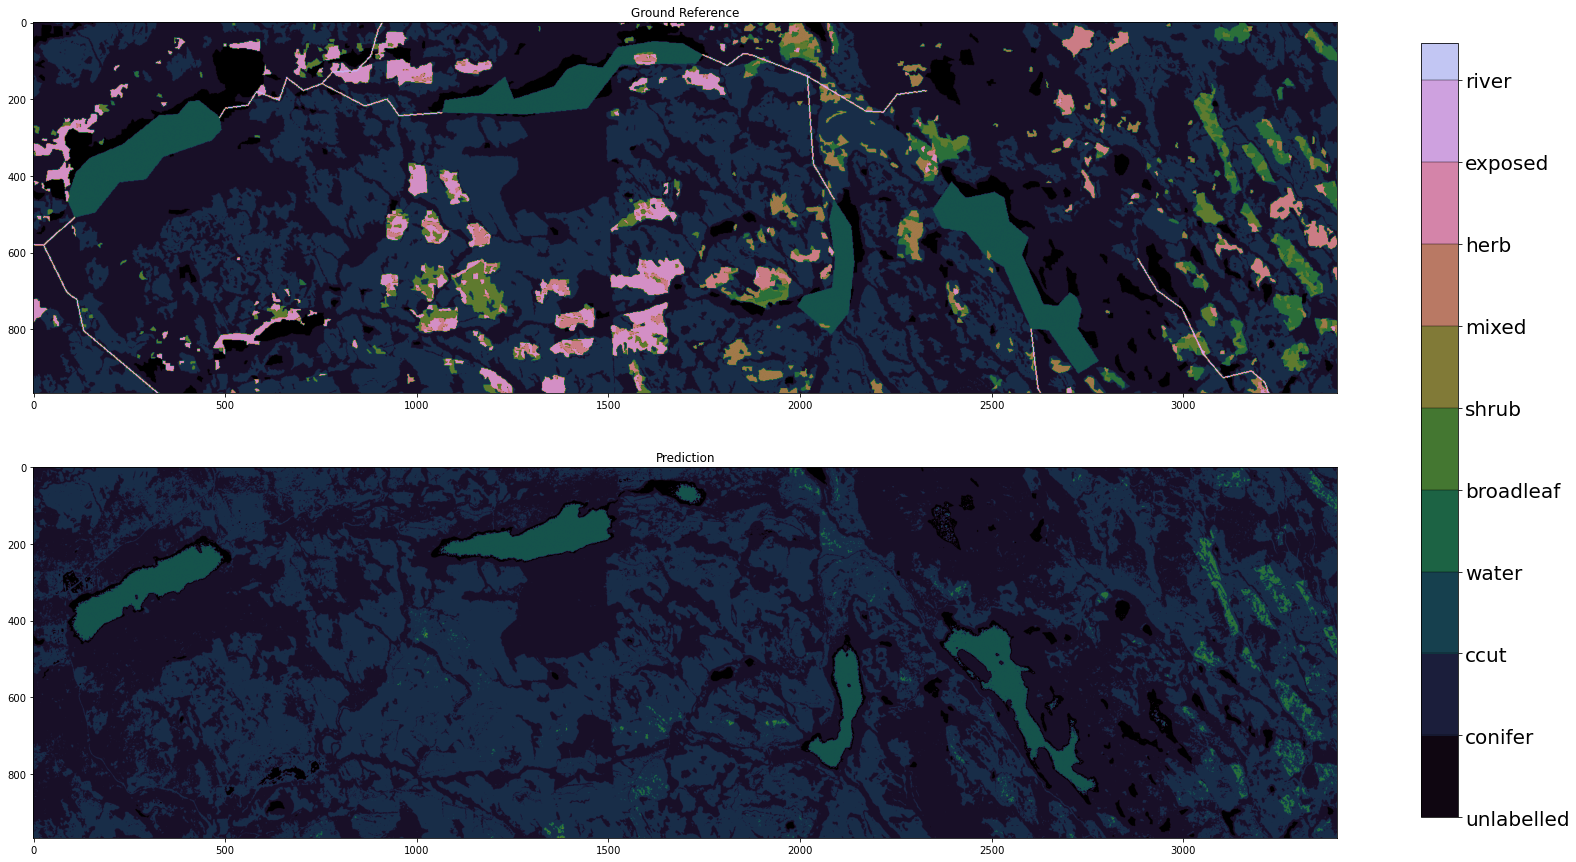

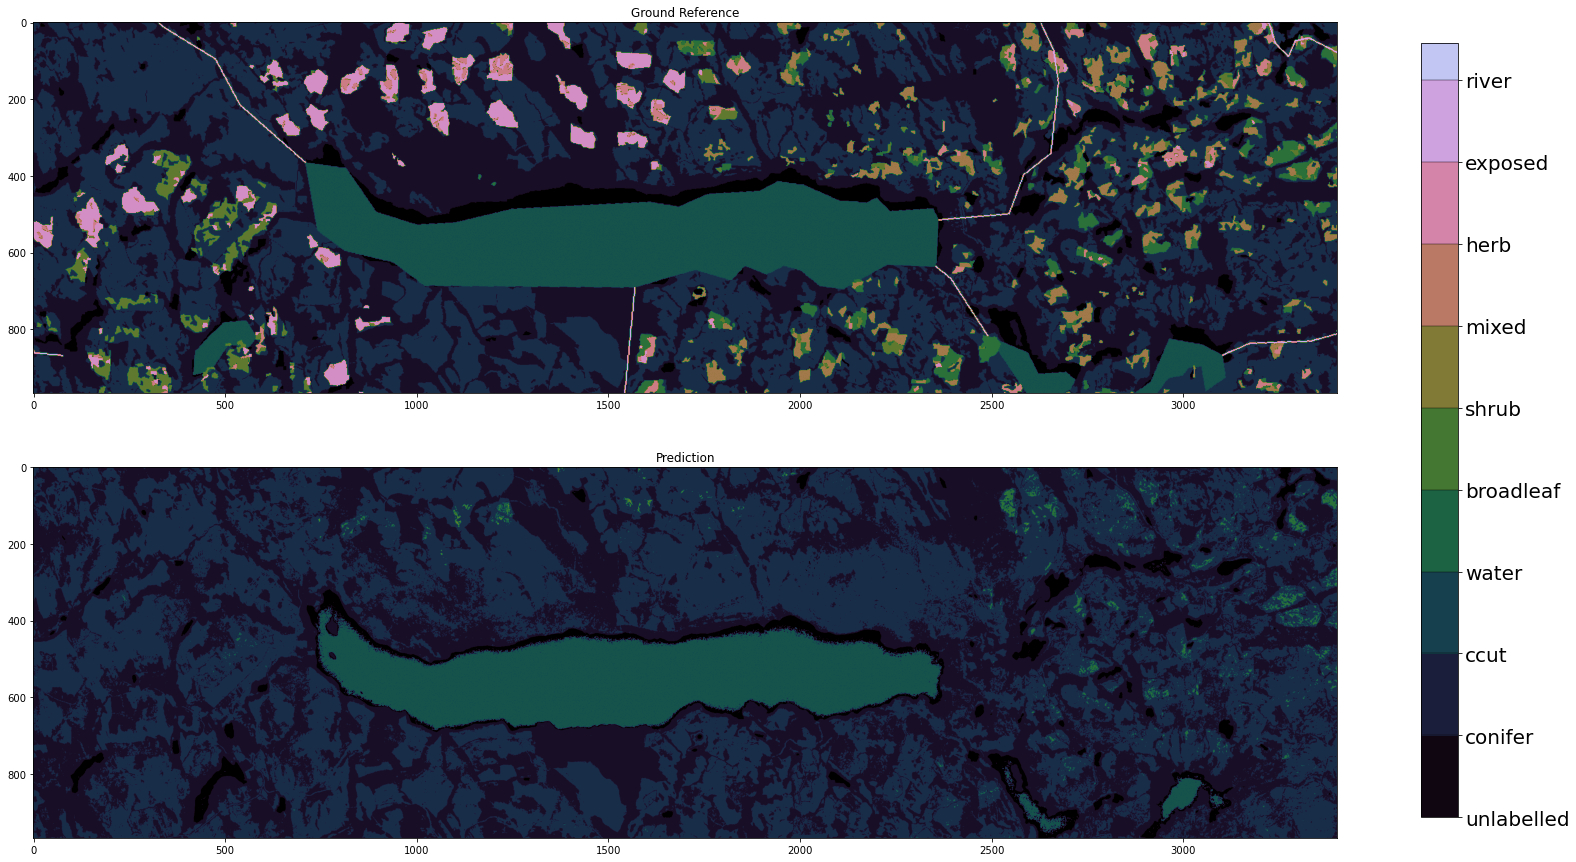

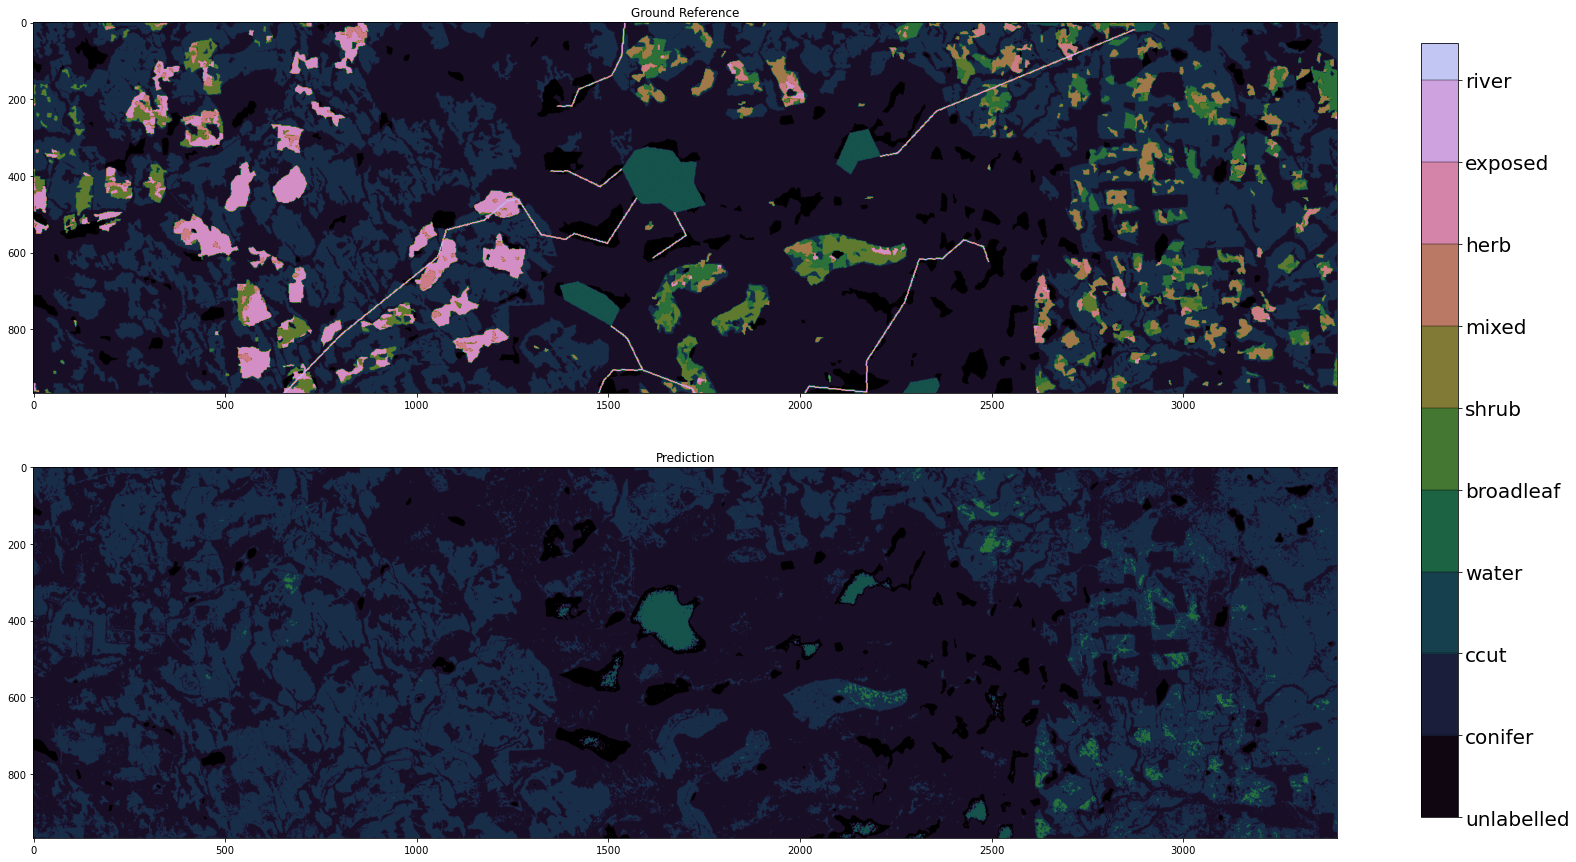

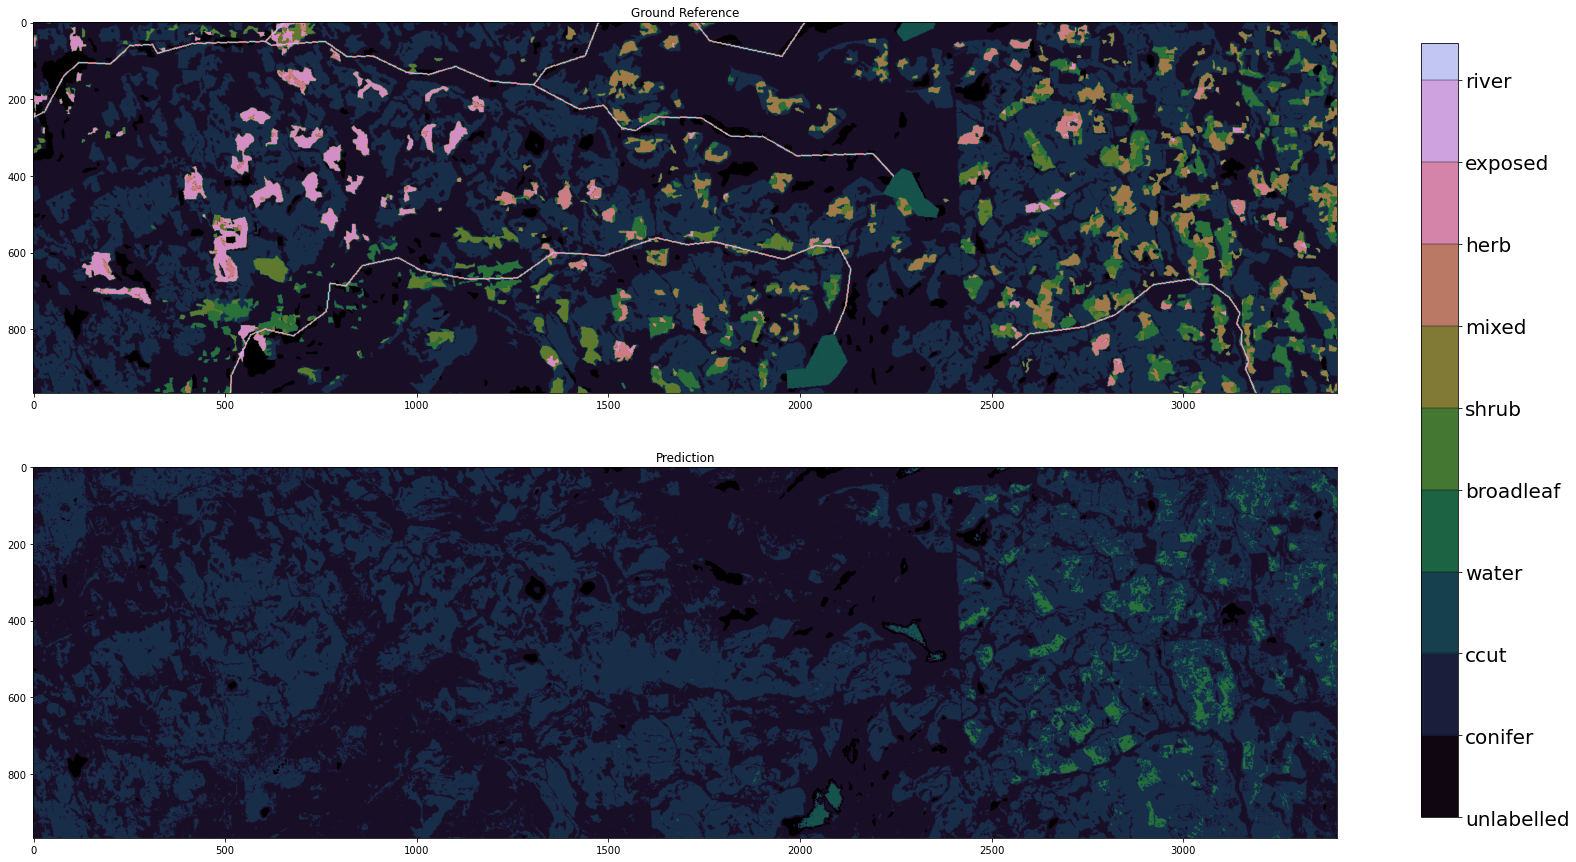

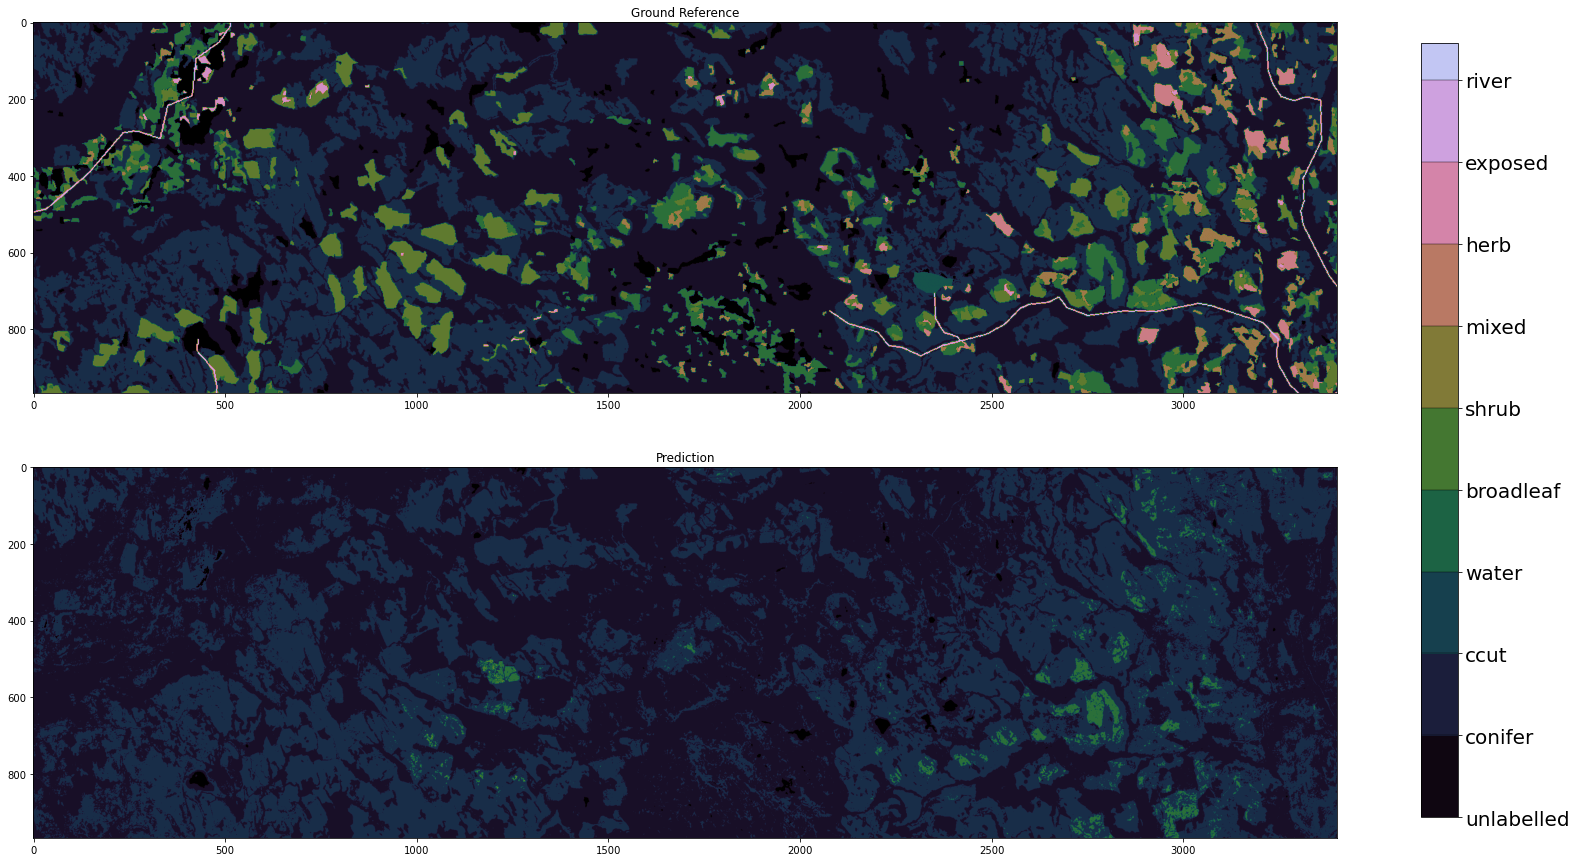

In [198]:
shape = (4835 // 5, 3402)
for idx in range(5):
    y_sub = y_subs[idx].reshape(shape)
    predict = predict_subs[idx].reshape(shape)
    
    f, ax = plt.subplots(2,1, sharey=True, figsize=(30,15))

    ax[0].imshow(y_sub, cmap='cubehelix', vmin=0, vmax=12)
    ax[0].set_title('Ground Reference')
    ax[1].imshow(predict, cmap='cubehelix', vmin=0, vmax=12)
    ax[1].set_title('Prediction')
    colormap_y = ax[0].imshow(y_sub, cmap='cubehelix', vmin=0, vmax=12)
    
    cbar = f.colorbar(colormap_y, 
                      ax=ax.ravel().tolist(), 
                      orientation='vertical',
                     boundaries=range(11), shrink=.95,extend='max', extendrect=True, drawedges=True, spacing='uniform')
    cbar.ax.set_yticklabels(["unlabelled",
            "conifer",
            "ccut",
            "water",
            "broadleaf",
            "shrub",
            "mixed",
            "herb",
            "exposed",
            "river",""],fontsize=20)
    plt.savefig(f'{outdir}/{idx}')
    plt.show()
    plt.close()

In [122]:
correct_classifications2 = np.logical_and(predict2, y)
np.sum(correct_classifications)/len(y)

NameError: name 'predict2' is not defined

In [ ]:
np.unique(predict2, return_counts=True)

In [ ]:
predict2 = predict2.reshape()

In [206]:
for idx in range(5):
    correct_classifcation = np.logical_and(predict_subs[idx], y_subs[idx])
    print(np.sum(correct_classifcation)/len(y_subs[idx]))

0.9471401031207994
0.9488682063656211
0.9492563836468237
0.9642873861534094
0.9695440421626794
